# <center>Kung Fu Pandas</center>

## <center>XGBoost</center>



# Librerias y Dataset

In [2]:
import pandas as pd
import numpy as np

import sklearn as sk
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from six import StringIO
import pydotplus
from IPython.display import Image  

from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('always')

In [3]:
#Cargo el dataset
from google.colab import drive
drive.mount('/content/drive')

hotel = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_train.csv')
hotel_t = pd.read_csv('/content/drive/MyDrive/Kung Fu Pandas/hotels_test.csv')
hotel = hotel[hotel['adr']>0]
hotel_orig = hotel_t.copy()
total_filas = hotel.shape[0]
hotel.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at /content/drive


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


(61028, 32)

### Preprocesamiento de Datos

In [4]:
hotel['children'].fillna(0,inplace = True)
hotel['country'].fillna('PRT',inplace = True)
hotel['agent'].fillna(0,inplace = True)
hotel['company'].fillna(0,inplace = True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-91881aae9238>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['children'].fillna(0,inplace = True)
<ipython-input-4-91881aae9238>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['country'].fillna('PRT',inplace = True)
<ipython-input-4-91881

In [5]:
columnas_eliminar=['meal','arrival_date_year','arrival_date_week_number','arrival_date_day_of_month','id','reservation_status_date']
hotel.drop(columnas_eliminar, axis='columns', inplace=True)
hotel_t.drop(columnas_eliminar, axis='columns', inplace=True)
hotel.columns.tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-5-ab72810bb20e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel.drop(columnas_eliminar, axis='columns', inplace=True)


['hotel',
 'lead_time',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'is_canceled']

Formateo las columnas para eliminar variables categoricas

In [6]:
def higher_probability(a,b):
    if a == b:
        return 0
    else:
        return 1

hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel['country'] = hotel['country'].apply(higher_probability,b='PTR')
hotel['reserved_room_type'] = hotel['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel['assigned_room_type'] = hotel['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel['company'] = hotel['company'].apply(higher_probability,b=0)
hotel['market_segment'] = hotel['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel['distribution_channel'] = hotel['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)

hotel_t['arrival_date_month'] = hotel_t['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)
hotel_t['country'] = hotel_t['country'].apply(higher_probability,b='PTR')
hotel_t['reserved_room_type'] = hotel_t['reserved_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10},na_action=None)
hotel_t['assigned_room_type'] = hotel_t['assigned_room_type'].map({'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'P':9,'L':10,'K':11,'I':12},na_action=None)
hotel_t['company'] = hotel_t['company'].apply(higher_probability,b=0)
hotel_t['market_segment'] = hotel_t['market_segment'].map({'Online TA':1,'Groups':2,'Offline TA/TO':3,'Direct':4,'Complementary':5,'Corporate':6,'Aviation':7,'Undefined':8},na_action=None)
hotel_t['distribution_channel'] = hotel_t['distribution_channel'].map({'TA/TO':1,'Direct':2,'Corporate':3,'GDS':4,'Undefined':5},na_action=None)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-20578e1cc9f7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotel['arrival_date_month'] = hotel['arrival_date_month'].map({'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12},na_action=None)


In [7]:
#Dummies
hotel = pd.get_dummies(hotel, columns=['deposit_type', 'hotel', 'customer_type'], drop_first=True)
hotel_t = pd.get_dummies(hotel_t, columns=['deposit_type', 'hotel', 'customer_type'], drop_first=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
target='is_canceled'
hotel_x=hotel.drop([target], axis='columns', inplace=False)


#Creo un dataset con la variable target
hotel_y = hotel[target].copy()

x_train, x_test, y_train, y_test = train_test_split(hotel_x.values, 
                                                    hotel_y.values, 
                                                    test_size=0.20,    #25% al conjunto de test
                                                    random_state=10,  #para poder reproducir el experimento
                                                    stratify=hotel[target].values) #estratificado para mantener proporcion

#Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_train)))
print('# Datos Prueba: {}'.format(len(x_test)))

#Verifico como quedaron balanceados
for split_name, split in zip(['% Positivos Entrenamiento','% Positivos Prueba'],[y_train,y_test]):
  print('{}: {:.3f}'.format(split_name,pd.Series(split).value_counts(normalize=True)[1]*100))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Datos Entrenamiento: 48822
# Datos Prueba: 12206
% Positivos Entrenamiento: 50.444
% Positivos Prueba: 50.442


# Creación del modelo

In [9]:
#Creo el modelo y lo entreno

import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=0, n_estimators=100)
xgb_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AUC: 0.9197764303341239
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6049
           1       0.85      0.82      0.83      6157

    accuracy                           0.83     12206
   macro avg       0.83      0.83      0.83     12206
weighted avg       0.83      0.83      0.83     12206



<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

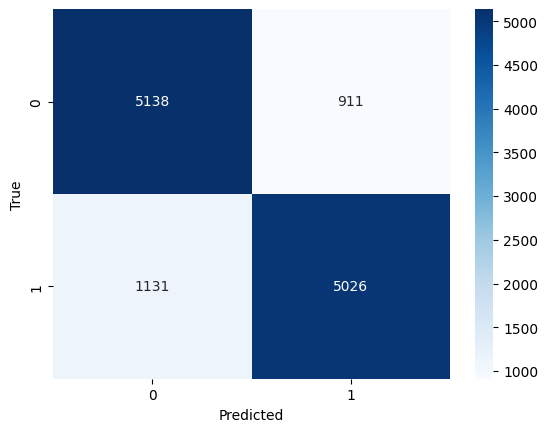

In [10]:
#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))


# Optimizando learning rate

In [11]:
from sklearn.metrics import f1_score
predictions = []

for lr in np.arange(0, 1, 0.1):

  # Definir el modelo XGBClassifier
  xgb_model = xgb.XGBClassifier(random_state=0, learning_rate=lr, n_estimators=100)

  # Entrenar el modelo con los datos de entrenamiento
  xgb_model.fit(x_train, y_train)

  #Realizo predicción
  y_pred=xgb_model.predict(x_test)

  #Agrego a lista
  predictions.append((lr,f1_score(y_test, y_pred)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


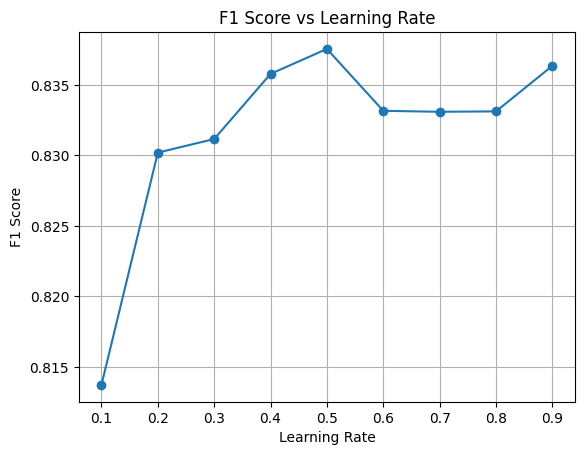

In [12]:
#ploteo predicciones
predictions.pop(0)
x_vals, y_vals = zip(*predictions)
plt.plot(x_vals, y_vals, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Learning Rate')
plt.grid(True)
plt.show()

# Modelo final (learning_rate=0.5)

In [13]:
# Definir el modelo XGBClassifier
xgb_model = xgb.XGBClassifier(random_state=0, learning_rate=0.5, n_estimators=100)

# Entrenar el modelo con los datos de entrenamiento
xgb_model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AUC: 0.9224238987256179
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      6049
           1       0.85      0.83      0.84      6157

    accuracy                           0.84     12206
   macro avg       0.84      0.84      0.84     12206
weighted avg       0.84      0.84      0.84     12206



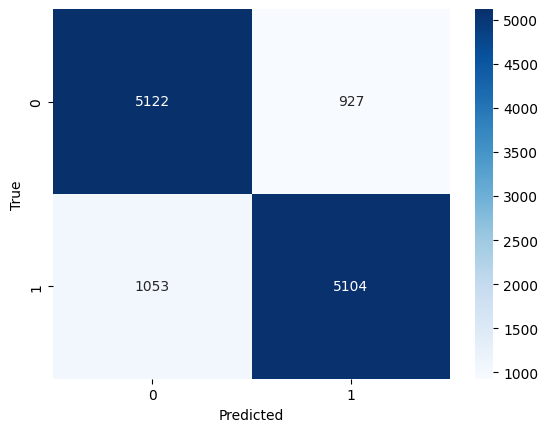

In [14]:
#Evaluo en el set de test
y_pred_proba= xgb_model.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, y_pred_proba))

#Matriz de Confusion
y_pred=xgb_model.predict(x_test)

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,y_pred))

# Predicción kaggle

In [15]:
y_pred_test = xgb_model.predict(hotel_t)

entregable = pd.DataFrame({'id': hotel_orig['id'], 'is_canceled':pd.Series(y_pred_test).astype(int)})
entregable.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

,id,is_canceled
0,e6d0d58a-ab96-44d3-b28f-85df1cc15f1e,1
1,aba9aac2-4495-4645-a60e-90328713c999,1
2,b345b5dc-c804-4d77-a39f-1f4e65d1f1ad,0
3,ce1b400e-afa1-4946-bdff-004b859eb61c,1
4,c4fbec0d-8e2e-4db2-9d4f-a6ccb9f51214,1


In [16]:
entregable.to_csv('XGBoost_predictions.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


# Exporto modelo

In [17]:
pickle.dump(xgb_model, open("XGB_model", "wb"))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>: